# MPO 624 - Homework 2

## Linear modeling in terms of "predictors" data (a.k.a. "regression")

Tiago Carrilho Bilo C#11950866


### Summary of what will be done: 

As we saw from the Homework 1: My data summary, the Meridional Heat Transport in the ocean (MHT) is function of the North Antlantic latitude and time. Therefore, it is desired to understand the characteristics of different components that consists the MHT signal in order to better understand the physical process involved. 

Based on the previous homework we decided to map the characteristics of the MHT temporal evolution at each latitude. In order to do that, lets linearly decompose the MHT signal ($d_{total}$) in four components:

   1 - Time average: $\bar{d}(Lat) = \frac{\sum^{N}_{i=1} d_{i}}{N}$; 

   2 - Linear trend ($a$): $d_{trend}(Lat) = a t$;

   3 - Seasonal signal: $d_{seasonal}(Lat) = A_{1} cos(\omega t) + A_{2} sin(\omega t)$, where $\omega = \frac{2\pi}{12 months}$;

   4 - Residual signal: $d_{residual}(Lat) = d_{total} - \bar{d} - d_{trend} - d_{seasonal}$. 



The signal components are obtained by solving the following linear system,

$$d_{total} = Gm,$$ where $G$ is the predictors matrix and $m$ is the signal components coefficients matrix (i. e., $\bar{d}$, $a$, $A_{1}$, $A_{2}$, and $d_{residual}$). The solution for m is obtained buy performing a least squares fitting given by: 

$$m = (G^{T} G)^{-1} (G^{T} d_{total})$$.




## Defining the predictiors matrix G

In [1]:
# importing libraries
import numpy as np
import pylab as py
import netCDF4 
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

# Unables latex syntax in string variables 
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True

# Nice graph sytle from old oeans package (https://github.com/ocefpaf/python-oceans)
from oceans_old.plotting import rstyle



### Importing the dataset to the memory

In [2]:
# Here I imported my dataset from a local repository, however it is available to download at
# https://drive.google.com/file/d/0B1zX-YKTIg_aWjFySVQ2S2lVUlU/view?usp=sharing
data = netCDF4.Dataset('/Users/Tiago/Google Drive/ecco2_mht.nc','r')

# Retriving varibles 
lat = data['lat'][:]
time = data['time'][:]                                           # Conventional "continous" time axis
date = netCDF4.num2date(time,'days since 1992-01-01 00:00:00')   # Python date system
mht = data['integrated_mht'][:]

data.close()


### G and m structures:

Remember that the dataset variable $mht$ (i.e., $d_{total}$) is organized as: 

$$mht(t,Lat) =
\begin{bmatrix}
MHT_{t1,l1} & MHT_{t1,l2} & . . . & MHT_{t1,lM} \\
MHT_{t2,l1} & MHT_{t2,l2} & . . . & MHT_{t2,lM} \\
. & . & ... & . \\
. & . & ... & . \\
. & . & ... & . \\
MHT_{tN,l1} & MHT_{tN,l2} & . . . & MHT_{tN,lM}
\end{bmatrix}$$


Therefore our predictors $G$ and signal components $m$ (or model), must be: 

$$G =
\begin{bmatrix}
1 & -1 & cos(\omega t1) & sin(\omega t1) & 1 \\ 
1 & -1+dt & cos(\omega t2) & sin(\omega t2) & 1 \\
. & . & ... & . & . \\
. & . & ... & . & . \\
. & . & ... & . & . \\
1 & +1 & cos(\omega tN) & sin(\omega tN) & 1
\end{bmatrix}$$

and 

$$m =
\begin{bmatrix}
\bar{d}_{l1} & \bar{d}_{l2} & ... & \bar{d}_{lM} \\
a_{l1} & a_{l2} & ... & a_{lM} \\
A_{1 l1} & A_{1 l2} & ... & A_{1 lM} \\
A_{2 l2} & A_{2 l2} & ... & A_{2 lM} \\
\end{bmatrix}$$



##### Simple proof of the G structure: 
Lets try to build the first column of the data matrix $d_{total}$ (i. e., time series at latitude1). Therefore m will be a column matrix with 5 lines (or signal components) ! 

taking the product 

$$G \times 
\begin{bmatrix}
\bar{d}_{l1} & \\
a_{l1} & \\
A_{1 l1} & \\
A_{2 l2} & \\
\end{bmatrix} 
=
\begin{bmatrix}
1 \bar{d}_{l1} - a_{l1} + cos(\omega t1) A_{1 l1} +  sin(\omega t1) A_{2 l1}\\
1 \bar{d}_{l1} + (-1+dt) a_{l1} + cos(\omega t2) A_{1 l1} +  sin(\omega t2) A_{2 l1}\\
.\\
.\\
.\\
1 \bar{d}_{l1} + a_{l1} + cos(\omega tN) A_{1 l1} +  sin(\omega tN) A_{2 l1}
\end{bmatrix}
=
Model$$

We know that the least-squares fitting does not generate perfect models, however it yields a model where the square of $d_{total} - Model = d_{residual}$ is minimal.

Also note that the trend is calculated around the time-average of each series.


In [3]:
## Building G
G = np.ones((time.shape[0],4))

print "Dimensions of G: N = %i, number of signal components = %i "%(G.shape[0],G.shape[1])

Dimensions of G: N = 264, number of signal components = 4 


In [4]:
# "time column" for the linear regression around the mean
G[:,1] = np.linspace(-1.,1.,G.shape[0])

# Cosine column
omega = 2.*np.pi/365.        # frenquency in cycles per year (i.e., seasonal variability signal)   
G[:,2] = np.cos(omega*time)
G[:,3] = np.sin(omega*time)

In [5]:
## Transforming the data and predictors python arrays to matrices - Using NumPy.matrix 
## (from now on all operations will matricial operations)

d = np.matrix(mht.copy())
G = np.matrix(G)

# e.g., 
G

matrix([[ 1.        , -1.        ,  1.        ,  0.        ],
        [ 1.        , -0.99239544,  0.86096102,  0.50867094],
        [ 1.        , -0.98479087,  0.51237141,  0.85876396],
        ..., 
        [ 1.        ,  0.98479087,  0.09025161, -0.995919  ],
        [ 1.        ,  0.99239544,  0.58429817, -0.81153906],
        [ 1.        ,  1.        ,  0.90881764, -0.4171936 ]])



### Computing m coefficients (i. e., decomposing the dataset signals)

$$m = (G^{T} G)^{-1} (G^{T} d_{total})$$

ps: This procidure could have been done by calling the least-squares fitting function NumPy.linalg.lstsq(G,d)


In [6]:
## Lets compute the different compoenents of this product
# Transpose of G x G
GtG = G.T*G

# Transpose of G x d
Gtd = G.T*d

# Inverting GtG (NumPy.linalg.inv) and multiplying by Gtd (i. e., obtaining the coefficients)
m = np.linalg.inv(GtG)*Gtd

print "As predicted m has the following dimensions: %i lines and %i columns"%(np.array(m).shape[0],np.array(m).shape[1])

As predicted m has the following dimensions: 4 lines and 240 columns




### Exploring the results: Checking the signal components, defining orthogonality, and reconstructing the dataset

#### Signal components - How do they look like?

1) Temporal average ($\bar{d}$): As we saw above, the time-averages at each Latitude should be the first line of m. 


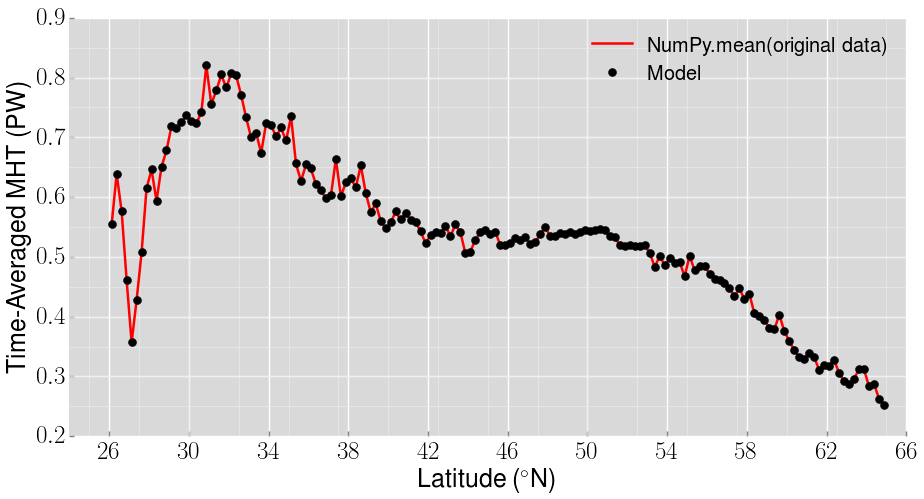

In [7]:
## Model and Residual signal
model = G*m
dr = d-model


## Time-avereged over each latitude  
da = m[0,:]


fig1 = plt.figure(num=1,figsize=(15,7.5),facecolor='w')
ax1 = plt.gca()

# Average using NumPy.mean
ax1.plot(lat,np.mean(mht,axis=0),color='r',lw=2.5,label='NumPy.mean(original data)')

# Modeled average
ax1.plot(lat,np.array(da).squeeze(),'ko',markersize=8,label='Model')

rstyle(ax1)

# Seting the axes (study area 26N<lat<65N)
ax1.set_xlim(24,65)
ax1.set_xticks(range(26,69,4))
ax1.tick_params(labelsize=25)

ax1.set_xlabel('Latitude ($^{\circ}$N)',fontsize=25,fontweight='bold')
ax1.set_ylabel(ur'Time-Averaged MHT (PW)',fontsize=25,fontweight='bold')

# Ploting some info about general statistics
ax1.legend(numpoints=1,loc=0,prop={'size':20},frameon=False)

Figure 1. True (red line) and modeled (black dots) time-averages at each latitude. Note that it is difficult to distinguish the differences between the curves, indicating that the residual signal averaged on time is very small and the trend were predicted well. 

#### Remember:
$$ \bar{mht} = \bar{Model} + \bar{d_{residual}} $$





2) Trends ($a$) and the linear regression: A linear model assumes the form of 

$$d(t) = at + b;$$

where $a$ is the second line of m 

In this specific signal decomposition we assumed

$$b = \bar{d} - \frac{a tN}{2}$$


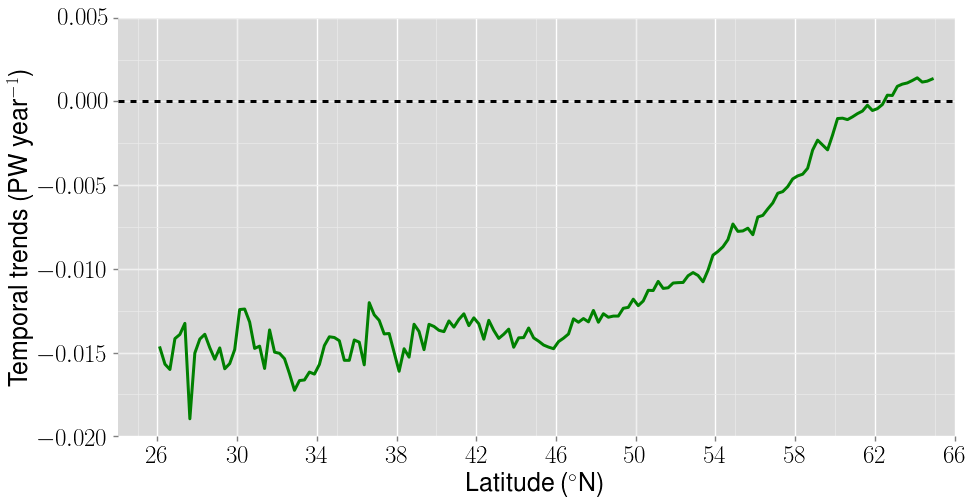

In [8]:
## Trends
a = m[1,:]              # [PW per weird time-fraction]
ad = 2.0*a/time.max()   # [PW day^-1]
ay = ad*365.0           # [PW year^-1]

## Spacial distribution of trends 
fig2 = plt.figure(num=2,figsize=(15,7.5),facecolor='w')
ax2 = plt.gca()

# Average using NumPy.mean
ax2.plot(lat,np.array(ay).squeeze(),color='g',lw=3.)
ax2.plot([24,66],[0,0],'k--',lw=3.)
rstyle(ax2)

# Seting the axes (study area 26N<lat<65N)
ax2.set_xlim(24,65)
ax2.set_xticks(range(26,69,4))
ax2.tick_params(labelsize=25)

ax2.set_xlabel('Latitude ($^{\circ}$N)',fontsize=25,fontweight='bold')
ax2.set_ylabel(ur'Temporal trends (PW year$^{-1}$)',fontsize=25,fontweight='bold')



Figure 2. Time series trends at each latitude. According to this model, the MHT at mid-latitudes (i. e., 26-48$^{\circ}$N or the subtropical gyre domain) is deacresing with time in a rate approximately 10 times faster than at higher latititudes $\approx$60-65$^{\circ}$N (i. e., in the subpolar gyre). 


But how significant are those trends to the dataset? To anwser that, we should look at the original dataset and the linear models at the same time.



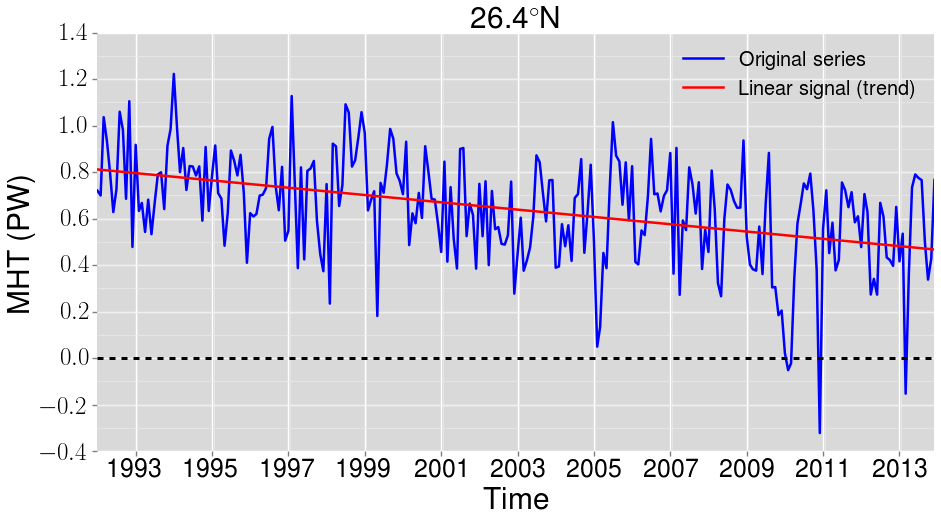

In [9]:
## Linear model (ax+b)
ad = np.array(ad).squeeze()
da = np.array(da).squeeze()

i26 = np.abs(lat-26.5).argmin()
dlinear = (ad[i26]*time) + da[i26] - (ad[i26]*time[-1]/2.) 

## MHT time-series at 26.4 N 
fig3 = plt.figure(num=3,figsize=(15,7.5),facecolor='w')
ax3 = plt.gca()

ax3.plot(date,mht[:,i26],color='b',lw=2.5,label='Original series')
ax3.plot(date,dlinear,'r',lw=2.5,label='Linear signal (trend)')
ax3.legend(numpoints=1,loc=0,prop={'size':20},frameon=False)
ax3.plot([date[0],date[-1]],[0,0],'k--',lw=3.0)
rstyle(ax3)


# Seting the axes (study area 26N<lat<65N)
ax3.set_xticks(date[range(12,253,24)])
ax3.tick_params(labelsize=25)

ax3.set_xlabel('Time',fontsize=30,fontweight='bold')
ax3.set_ylabel(ur'MHT (PW)',fontsize=30,fontweight='bold')
ax3.set_title(ur'%1.1f$^{\circ}$N'%(lat[i26]),fontsize=30,fontweight='bold')


Figure 3. Least-squares linear fitting. Note that the signal has a distinguishable trend at 26.4$^{\circ}$N (and at latitudes lower than 60$^{\circ}$N). 



3) Seasonal variability ($d_{seasonal}$): In order to check how good is the seasonal cycle model to explain the dataset temporal variability, we should compare the MHT detrended anomalies (i.e., $mht - (ax + b)$) with the seasonal oscillations $A_{1} cos(\omega t) + A_{2} sin(\omega t)$.

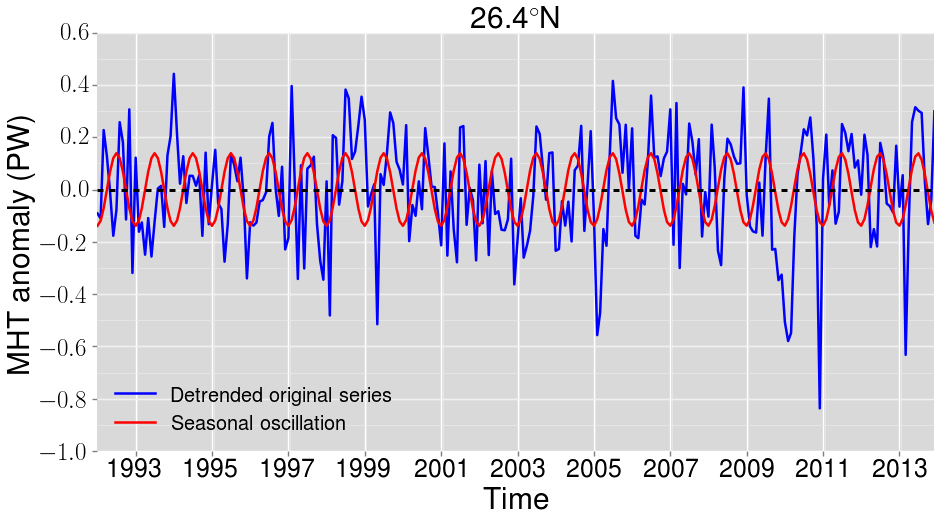

In [10]:
## Detrending the time series at 26.5N as an example (remember it can be applied in all data set)
detrended_mht = mht[:,i26].squeeze()-dlinear.squeeze()
seasonal_signal  = (np.array(m[2,i26])*np.cos(omega*time)) + (np.array(m[3,i26])*np.cos(omega*time))


## MHT time-series at 26.4 N 
fig4 = plt.figure(num=4,figsize=(15,7.5),facecolor='w')
ax4 = plt.gca()

ax4.plot(date,detrended_mht,color='b',lw=2.5,label='Detrended original series')
ax4.plot(date,seasonal_signal,'r',lw=2.5,label='Seasonal oscillation')
ax4.legend(numpoints=1,loc=0,prop={'size':20},frameon=False)
ax4.plot([date[0],date[-1]],[0,0],'k--',lw=3.0)
rstyle(ax4)


# Seting the axes (study area 26N<lat<65N)
ax4.set_xticks(date[range(12,253,24)])
ax4.tick_params(labelsize=25)

ax4.set_xlabel('Time',fontsize=30,fontweight='bold')
ax4.set_ylabel(ur'MHT anomaly (PW)',fontsize=30,fontweight='bold')
ax4.set_title(ur'%1.1f$^{\circ}$N'%(lat[i26]),fontsize=30,fontweight='bold')



Figure 4. Seasonal cycle fitting to the original series. As expected, the sinusoidal signal does not perfectly explain all the variability observed in the data set (e. g., strong negative anomalies). It is important to mention we have arbitrarily chosen this wave function based on we guess it is the major variability frequency.  

4) Residual signal ($d_{residual}$): this will show how good our model is !

$$d_{residual} = mht - Model$$

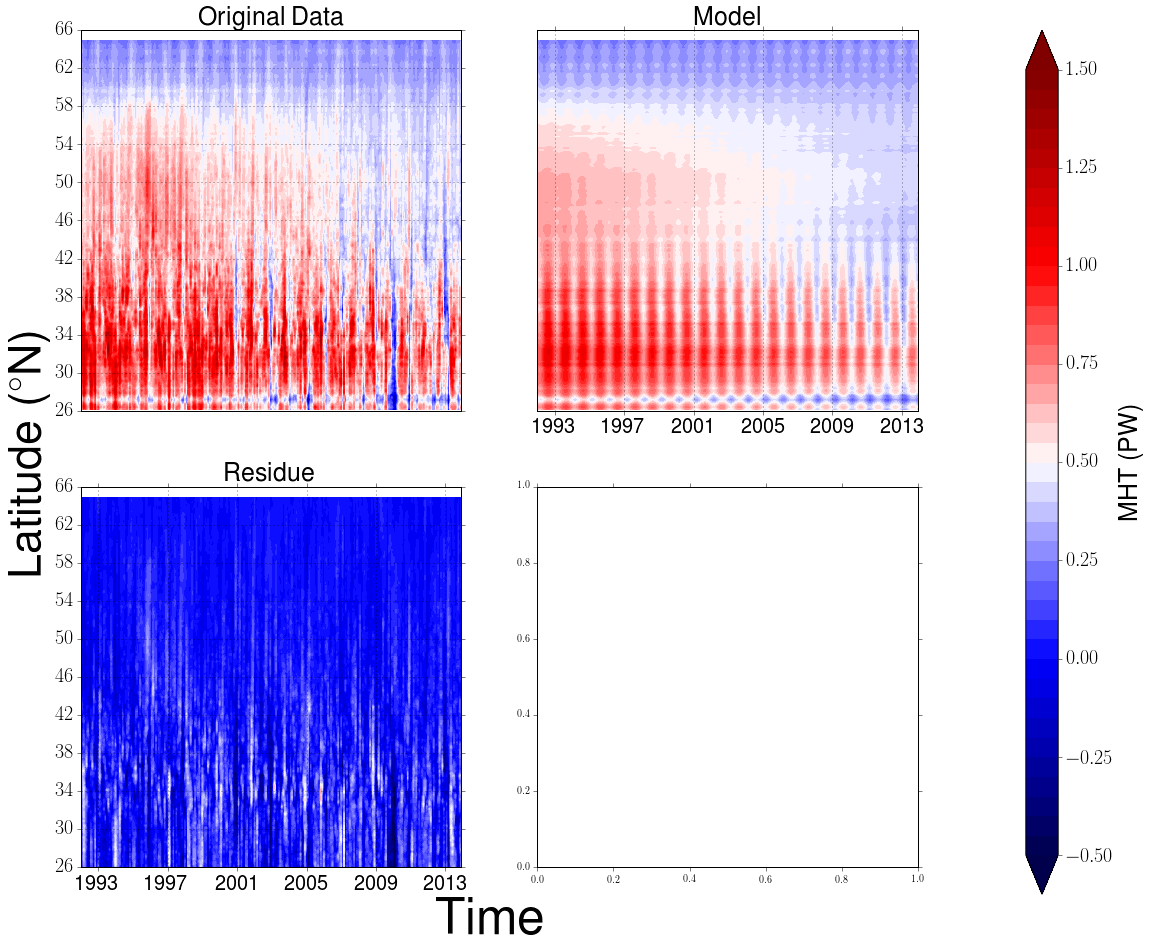

In [11]:


## Model x Original data x Residual 
fig5,axes5 = plt.subplots(figsize=(15,15),nrows=2,ncols=2,facecolor='w')


# Ploting data
cm1 = axes5[0,0].contourf(date,lat,np.array(d.T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both')
cm2 = axes5[0,1].contourf(date,lat,np.array(model.T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both')
cm3 = axes5[1,0].contourf(date,lat,np.array(dr.T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both')
                          
# Seting the colorbar
cbaxes1 = fig5.add_axes([1., 0.1, 0.03, 0.8])
cb1 = fig1.colorbar(cm1,cax=cbaxes1,extend='both',ticks=np.arange(-0.5,1.75,0.25)) 
cb1.ax.tick_params(labelsize=20)
cb1.set_label('MHT (PW)',fontsize=25,fontweight='bold')

# Seting titles
axes5[0,0].set_title('Original Data',fontsize=25,fontweight='demibold')
axes5[0,1].set_title('Model',fontsize=25,fontweight='demibold')
axes5[1,0].set_title('Residue',fontsize=25,fontweight='demibold')

# Seting the axes (study area 26N<lat<65N)
axes5[0,0].set_ylim(26,65); axes5[0,1].set_ylim(26,66); axes5[1,0].set_ylim(26,65)
axes5[0,0].set_yticks(range(26,69,4)); axes5[0,1].set_yticks([]); axes5[1,0].set_yticks(range(26,69,4))
axes5[0,0].set_xticks([]); axes5[0,1].set_xticks(date[range(12,253,48)]); axes5[1,0].set_xticks(date[range(12,253,48)])
axes5[0,0].tick_params(labelsize=20); axes5[0,1].tick_params(labelsize=20); axes5[1,0].tick_params(labelsize=20)

axes5[0,0].set_ylabel(ur"Latitude ($^{\circ}$N)",fontsize=45,fontweight='bold',y=-0.105)
axes5[1,0].set_xlabel("Time",fontsize=50,fontweight='bold',x=1.08)

axes5[0,0].grid('on'); axes5[0,1].grid('on'); axes5[1,0].grid('on')

Figure 5. Comparison between the original data, idealized model and the residual signal. As we suspected the linear trends and seasonal variability can explain most of the original signal (i. e., main features). Only some strong positive and negative anomalies were not reproduced by the model. From the residue pannel, most of the residual variability are related to frequencies higher than the seasonal at mid-latitudes. 

#### Defining orthogonality 

In our case, if all predictors are orthogonal the matrix G is also orthogal. This means that 

$$ G^{T} \times G = I$$

The indentity matrix $I$ is a square matrix (e. g., four by four in this problem), with only the primary diagonal different of zero. As we can see bellow, we have non-orthogonal predictors (e.g, linear and wave-like functions).

In [12]:
GtG

matrix([[ 264.        ,    0.        ,    0.98668849,    1.06762328],
        [   0.        ,   88.66920152,   -0.85817477,   -3.77042394],
        [   0.98668849,   -0.85817477,  131.72738278,    0.3831636 ],
        [   1.06762328,   -3.77042394,    0.3831636 ,  132.27261722]])

#### Reconstructing the dataset: effects of subseting and noise

In terms of subseting the data, the result will be the model coefficients that better fitts the new dataset (i. e., average, linear trends and seasonal cycle amplitudes will be afected depending on how the subsetting were performed). If you build a model for the second half of the time series the |residual signal| of te first half of the time series will be "poorly" represented by the model. 

For our case it should not affect that much the coefficients because our signal is mainly composed by a linear trend + and oscillations that repeats it self a cuple of times in each half of the series.



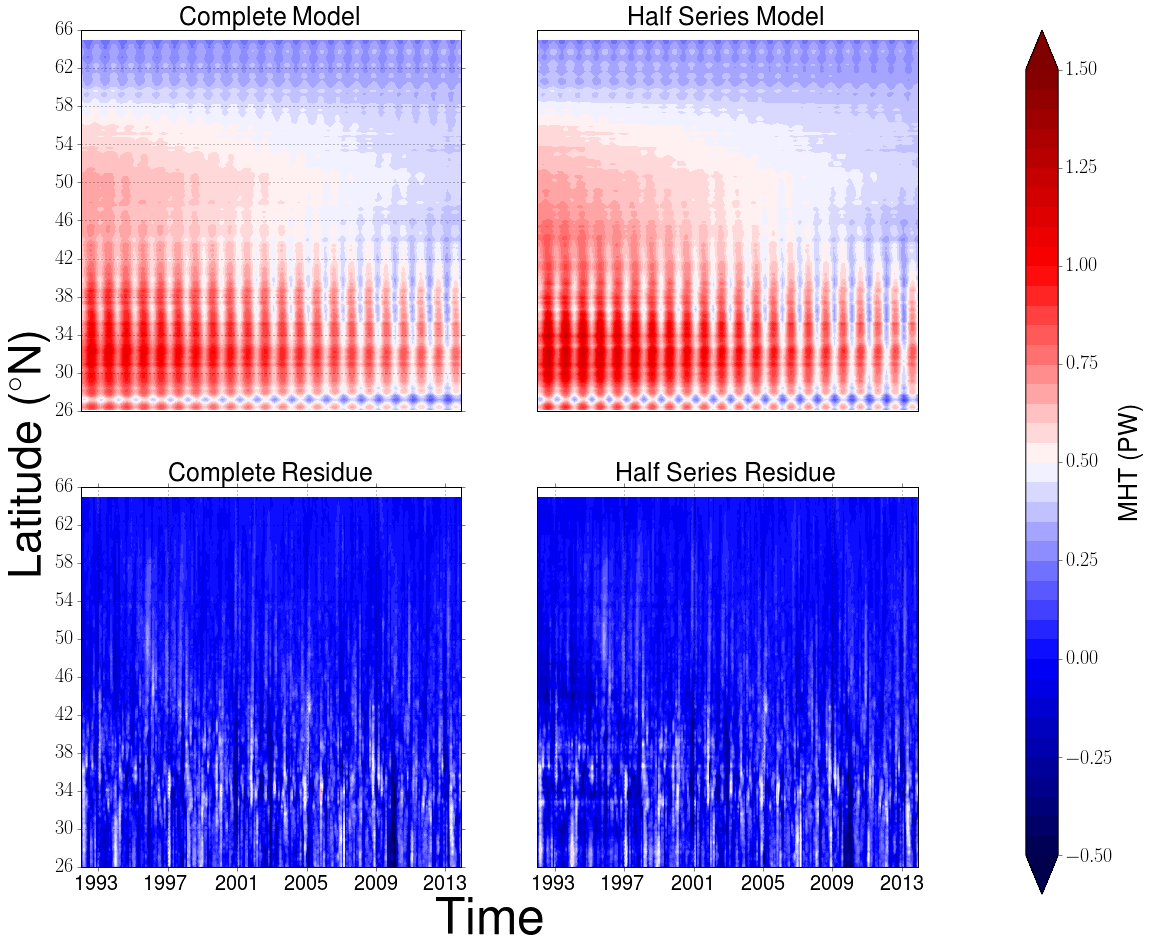

In [13]:
## Cutting the data in half
# Now solving the problem using linear algebra packages from NumPy
m_half = np.linalg.lstsq(G[np.int(mht.shape[0]/2):,:],d[np.int(mht.shape[0]/2):,:])[0]
dr_half = d-(G*m_half)


## Model x Model of half data x Residual x Residue of half data 
fig6,axes6 = plt.subplots(figsize=(15,15),nrows=2,ncols=2,facecolor='w')


# Ploting data
cm1 = axes6[0,0].contourf(date,lat,np.array(model.T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both')
cm2 = axes6[0,1].contourf(date,lat,np.array((G*m_half).T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both')
cm3 = axes6[1,0].contourf(date,lat,np.array(dr.T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both')
cm4 = axes6[1,1].contourf(date,lat,np.array(dr_half.T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both') 
    
# Seting the colorbar
cbaxes1 = fig6.add_axes([1., 0.1, 0.03, 0.8])
cb1 = fig6.colorbar(cm1,cax=cbaxes1,extend='both',ticks=np.arange(-0.5,1.75,0.25)) 
cb1.ax.tick_params(labelsize=20)
cb1.set_label('MHT (PW)',fontsize=25,fontweight='bold')

# Seting titles
axes6[0,0].set_title('Complete Model',fontsize=25,fontweight='demibold')
axes6[0,1].set_title('Half Series Model',fontsize=25,fontweight='demibold')
axes6[1,0].set_title('Complete Residue',fontsize=25,fontweight='demibold')
axes6[1,1].set_title('Half Series Residue',fontsize=25,fontweight='demibold')

# # Seting the axes (study area 26N<lat<65N)
axes6[0,0].set_ylim(26,65); axes6[0,1].set_ylim(26,66); axes6[1,0].set_ylim(26,65); axes6[1,1].set_ylim(26,66)
axes6[0,0].set_yticks(range(26,69,4)); axes6[0,1].set_yticks([]); axes6[1,0].set_yticks(range(26,69,4)); axes6[1,1].set_yticks([])
axes6[0,0].set_xticks([]); axes6[0,1].set_xticks([]); axes6[1,0].set_xticks(date[range(12,253,48)]); axes6[1,1].set_xticks(date[range(12,253,48)])
axes6[0,0].tick_params(labelsize=20); axes6[0,1].tick_params(labelsize=20); axes6[1,0].tick_params(labelsize=20);axes6[1,1].tick_params(labelsize=20)

axes6[0,0].set_ylabel(ur"Latitude ($^{\circ}$N)",fontsize=45,fontweight='bold',y=-0.105)
axes6[1,0].set_xlabel("Time",fontsize=50,fontweight='bold',x=1.08)

axes6[0,0].grid('on'); axes6[0,1].grid('on'); axes6[1,0].grid('on'); axes6[1,1].grid('on')


Figure 6. As expected the first half of t he time series present slightly darker colors in the first half of the time series, however main features of the dataset is preseverd in both models, due to the characteristics of the signal and length of the time series. A more drastic changes would be observed if we repeat the experiment for 1/5 of the series.


In terms of noise effects on the dataset, everything that if not resolved by the model fitts in the category of noise. Therefore if we add some "noise" to the matrix d that are unrelated to signal (i. e., oscillations with frequencies different that the seasonal, and no linear trends or average $\neq$ = 0), the model coefficients will be the same however the noise will added to the residual signal.  

It is important to mention that low-frequency variability that are not resolved by the time series will be accounted as trends in the model. 

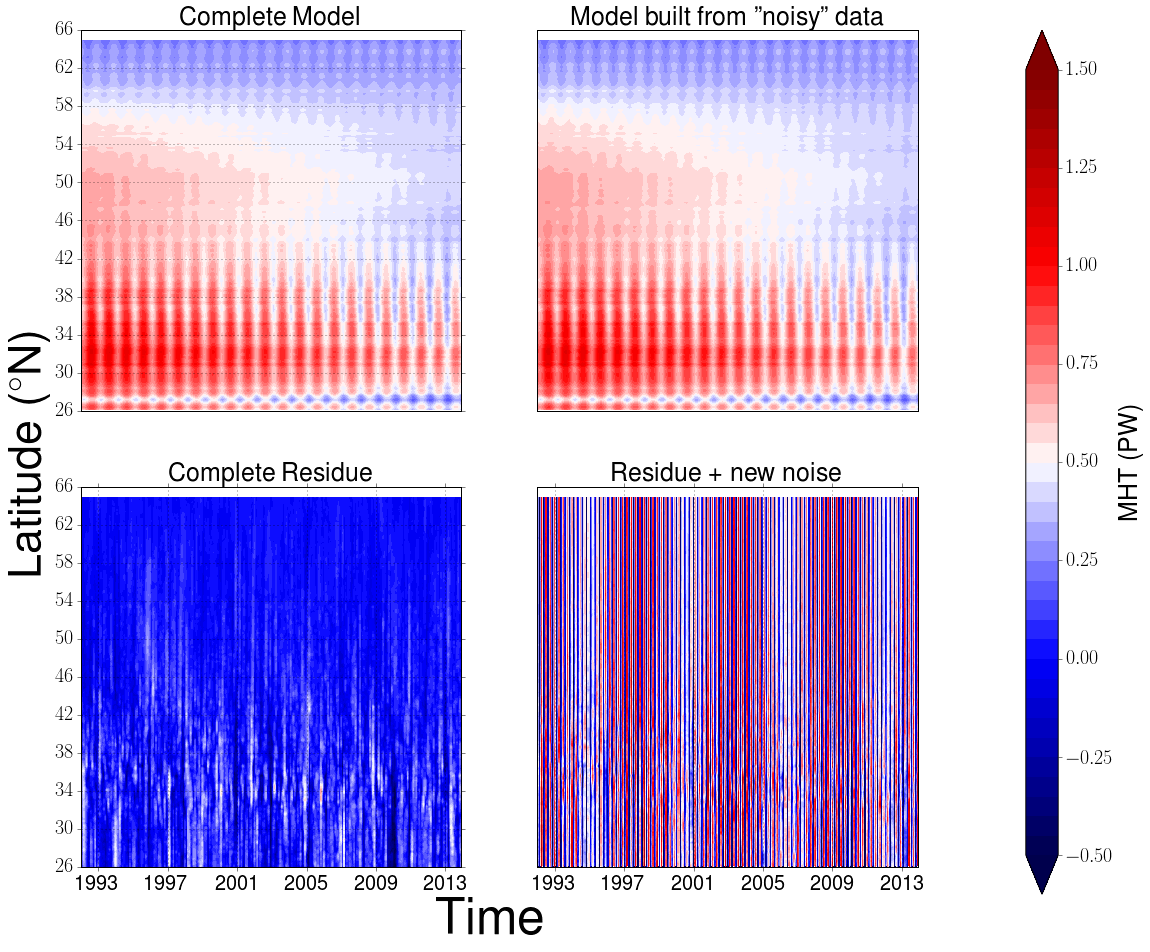

In [14]:
## Adding relative high-frequency signal (i.e., oscillatory noise)

# Noise (amplitude 1 PW and frequency of 1 cycle per 3 months)
n = mht*np.nan
for j in xrange(n.shape[1]):
    n[:,j] = 1.*np.cos(2.*np.pi*time/90.)

n = np.matrix(n)    
    
# Transpose of G x d
Gtd_noisy = G.T*(d+n)

# Inverting GtG (NumPy.linalg.inv) and multiplying by Gtd (i. e., obtaining the coefficients)
m_noisy = np.linalg.inv(GtG)*Gtd_noisy

# Residue with the new noise
dr_noisy = (d+n)-(G*m_noisy)


## Model x Model of half data x Residual x Residue of half data 
fig7,axes7 = plt.subplots(figsize=(15,15),nrows=2,ncols=2,facecolor='w')


# Ploting data
cm1 = axes7[0,0].contourf(date,lat,np.array(model.T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both')
cm2 = axes7[0,1].contourf(date,lat,np.array((G*m_noisy).T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both')
cm3 = axes7[1,0].contourf(date,lat,np.array(dr.T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both')
cm4 = axes7[1,1].contourf(date,lat,np.array(dr_noisy.T),np.arange(-0.5,1.55,0.05),cmap='seismic',extend='both') 
    
# Seting the colorbar
cbaxes1 = fig7.add_axes([1., 0.1, 0.03, 0.8])
cb1 = fig7.colorbar(cm1,cax=cbaxes1,extend='both',ticks=np.arange(-0.5,1.75,0.25)) 
cb1.ax.tick_params(labelsize=20)
cb1.set_label('MHT (PW)',fontsize=25,fontweight='bold')

# Seting titles
axes7[0,0].set_title('Complete Model',fontsize=25,fontweight='demibold')
axes7[0,1].set_title('Model built from "noisy" data',fontsize=25,fontweight='demibold')
axes7[1,0].set_title('Complete Residue',fontsize=25,fontweight='demibold')
axes7[1,1].set_title('Residue + new noise',fontsize=25,fontweight='demibold')

# # Seting the axes (study area 26N<lat<65N)
axes7[0,0].set_ylim(26,65); axes7[0,1].set_ylim(26,66); axes7[1,0].set_ylim(26,65); axes7[1,1].set_ylim(26,66)
axes7[0,0].set_yticks(range(26,69,4)); axes7[0,1].set_yticks([]); axes7[1,0].set_yticks(range(26,69,4)); axes7[1,1].set_yticks([])
axes7[0,0].set_xticks([]); axes7[0,1].set_xticks([]); axes7[1,0].set_xticks(date[range(12,253,48)]); axes7[1,1].set_xticks(date[range(12,253,48)])
axes7[0,0].tick_params(labelsize=20); axes7[0,1].tick_params(labelsize=20); axes7[1,0].tick_params(labelsize=20);axes7[1,1].tick_params(labelsize=20)

axes7[0,0].set_ylabel(ur"Latitude ($^{\circ}$N)",fontsize=45,fontweight='bold',y=-0.105)
axes7[1,0].set_xlabel("Time",fontsize=50,fontweight='bold',x=1.08)

axes7[0,0].grid('on'); axes7[0,1].grid('on'); axes7[1,0].grid('on'); axes7[1,1].grid('on')